## HAR_CNN model 
#### Add LC candidate from matlab as feature

In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pickle
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import classification_report

seed = 7
np.random.seed(seed)

c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '../Data/'
gpu_use = 'single' ## 'multi', 'single'
gpu_num = 0

In [3]:
## multi-GPU
if gpu_use == 'multi':
    NGPU = torch.cuda.device_count()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## single-GPU
elif gpu_use == 'single':
    device = torch.device("cuda:{}".format(gpu_num) if torch.cuda.is_available() else "cpu")

In [4]:
## Load_data
with open(file_path + 'data_no_std.pkl', 'rb') as f:
     dataset = pickle.load(f)

train_X = dataset[0]
test_X = dataset[1]
train_y = dataset[2]
test_y = dataset[3]

In [5]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(2746, 32, 13)
(687, 32, 13)
(2746,)
(687,)


### Model description

- InputLayer (32(timeseries_length)* 13(features))
- (batch, 32, 13) -> (batch, 16, 26)
- 1d conv (kernel size 2 , stride 1 )
- maxpooling 1d (pool size 2, stride 2)   (Pool size: size of the max pooling window , == kernel size)

- (batch, 16,26) -> (batch, 8, 52)
- 1d conv (kernel size 2 , stride 1 )
- maxpooling 1d (pool size 2, stride 2)

- (batch, 8,52) -> (batch, 4, 104)
- 1d conv (kernel size 2 , stride 1)
- maxpooling 1d (pool size 2, stride 2) 

- (batch, 4,104) -> (batch, 2, 208)
- 1d conv (kernel size 2 , stride 1)
- maxpooling 1d (pool size 2, stride 2)

- flatten  (-1, 32*13)
- dropout(0.5)
- dense(5)

In [6]:
## set model(CNN)

class CNN(nn.Module):
    def __init__(self, in_channel=30, out_channel=11):
        super(CNN, self).__init__()
        
        self.conv1d_1 = nn.Conv1d(in_channels = in_channel, out_channels = 26, kernel_size = 2, stride = 1 , padding = 'same')
        self.MaxPool1d_1 = nn.MaxPool1d(kernel_size = 2, stride =2)
        self.conv1d_2 = nn.Conv1d(in_channels = 26, out_channels = 52, kernel_size = 2, stride = 1, padding = 'same' )
        self.MaxPool1d_2 = nn.MaxPool1d(kernel_size = 2, stride =2)
        self.conv1d_3 = nn.Conv1d(in_channels = 52, out_channels = 104, kernel_size = 2, stride = 1, padding = 'same' )
        self.MaxPool1d_3 = nn.MaxPool1d(kernel_size = 2, stride =2)
        self.conv1d_4 = nn.Conv1d(in_channels = 104, out_channels = 208, kernel_size = 2, stride = 1, padding = 'same' )
        self.MaxPool1d_4 = nn.MaxPool1d(kernel_size = 2, stride =2)   
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p = 0.5)
        self.dense = nn.Linear(32*13, out_channel)
        
    def forward(self, x):
	# Raw x shape : (B, S, F) => (B, 32, 13)
        
        x = x.transpose(1,2)
        #  x shape : (B,F,S) => (B, 13, 32)
        x = self.conv1d_1(x)
        x = self.MaxPool1d_1(x)
        x = self.conv1d_2(x)
        x = self.MaxPool1d_2(x)
        x = self.conv1d_3(x)
        x = self.MaxPool1d_3(x)
        x = self.conv1d_4(x)
        x = self.MaxPool1d_4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)

        return x

In [7]:
## model training 

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

dataset = TensorDataset(train_X, train_y)
loader = DataLoader(dataset, batch_size = 1000, shuffle=True, drop_last=False)

num_epochs = 2000
lr = 0.0015

in_channel=13
out_channel=5 ##output class

## multi GPU    
if gpu_use == 'multi':
    model = CNN(in_channel, out_channel)
    if NGPU > 1:
        model = nn.DataParallel(model, device_ids = list(range(NGPU)))
    # torch.multiprocessing.set_start_method('spawn')
    model.to(device)

## single GPU
elif gpu_use == 'single':
    model = CNN(in_channel, out_channel).to(device)

criterion = nn.CrossEntropyLoss().to(device) #Loss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=lr) #optimizer SGD

#Train the model

for epoch in range(num_epochs):
    for train_X,train_y in loader:
        train_X = train_X.to(device)
        train_y = train_y.type(torch.LongTensor)
        train_y = train_y.to(device)
        outputs = model(train_X)
        # obtain loss function
        loss = criterion(outputs, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        print("Epoch: {}, loss:{}".format(epoch, loss.item()))

c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 0, loss:4.050541400909424
Epoch: 50, loss:0.4705102741718292
Epoch: 100, loss:0.28858867287635803
Epoch: 150, loss:0.30371975898742676
Epoch: 200, loss:0.25728103518486023
Epoch: 250, loss:0.20637653768062592
Epoch: 300, loss:0.19093091785907745
Epoch: 350, loss:0.18043819069862366
Epoch: 400, loss:0.17329072952270508
Epoch: 450, loss:0.23333615064620972
Epoch: 500, loss:0.15498504042625427
Epoch: 550, loss:0.11708098649978638
Epoch: 600, loss:0.10481377691030502
Epoch: 650, loss:0.11289607733488083
Epoch: 700, loss:0.10022169351577759
Epoch: 750, loss:0.12987598776817322
Epoch: 800, loss:0.05719437822699547
Epoch: 850, loss:0.07480432093143463
Epoch: 900, loss:0.061224862933158875
Epoch: 950, loss:0.06411716341972351
Epoch: 1000, loss:0.07038040459156036
Epoch: 1050, loss:0.04608440026640892
Epoch: 1100, loss:0.03512474149465561
Epoch: 1150, loss:0.08633940666913986
Epoch: 1200, loss:0.024043651297688484
Epoch: 1250, loss:0.10868626832962036
Epoch: 1300, loss:0.0411740355193614

In [8]:
## Inference for test data 

with torch.no_grad(): #off the autograd / memory 절약, calculation speed up 
    model.eval() #dropout layer와 같이 training / inference 시에 다르게 동작하는 layer를 inference(eval) mode로 바꾸어줌 
    inputs = test_X.to(device)
    outputs = model(inputs)
    print(outputs)
    print(outputs.shape)

tensor([[  4.3031, -35.8335,   0.2390,   9.6413,  -1.1546],
        [  2.6157, -13.4535,  12.7099, -21.0222, -16.2019],
        [ 16.5091, -30.6403,   0.4576, -12.0509, -21.2960],
        ...,
        [ 15.4000, -19.2864,  -3.6911, -17.6958, -17.9336],
        [ -1.6744, -38.2342,  24.5256, -12.9024,  -4.0654],
        [  4.4213, -20.7512,  11.5920, -15.3435, -10.4345]])
torch.Size([687, 5])


In [9]:
print(torch.round(F.softmax(outputs, dim=1), decimals=2)) #to represent as prob for each label
# print(outputs.argmax(1))  
pred = outputs.argmax(1).cpu().numpy() #torch tensor to numpy array obj 

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


In [10]:
# ### Model save and load by pytorch
# path = 'saved_model/'

# ## model save (architecture + param)
# torch.save(model, path+'CNN_supervised.pt')

# ## model save (only param)
# torch.save(model.state_dict(), path+'CNN_supervised_param.pt')

# ## model load (architecture + param)
# torch.load(path+'CNN_supervised.pt')

# ## model load(only param , for same model structure )
# new_model = model #conv1d_lstm model structure
# new_model.load_state_dict(torch.load(path+'CNN_supervised_param.pt'))

accuracy:0.9272197962154294
Precision: 0.675828
Recall: 0.624970
F1 score: 0.644832


c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


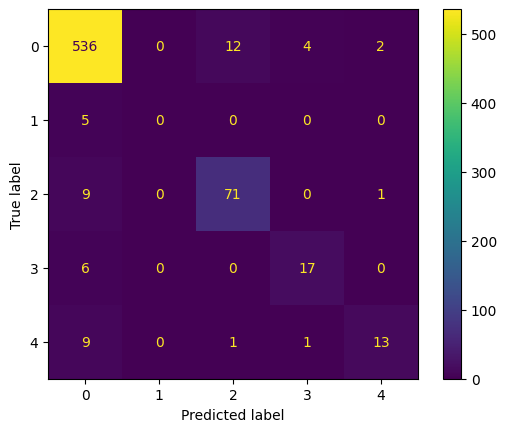

In [11]:
## model evaluation by test set 

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 

oos_y = []
oos_pred = []

test_y.numpy()
oos_y.append(test_y)
oos_pred.append(pred)
y_compare = test_y


score = accuracy_score(y_compare, pred)
print("accuracy:{}".format(score))
precision = precision_score(y_compare, pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_compare, pred, average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_compare, pred, average='macro')
print('F1 score: %f' % f1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_compare, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(test_y, pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       554
         1.0       0.00      0.00      0.00         5
         2.0       0.85      0.88      0.86        81
         3.0       0.77      0.74      0.76        23
         4.0       0.81      0.54      0.65        24

    accuracy                           0.93       687
   macro avg       0.68      0.62      0.64       687
weighted avg       0.92      0.93      0.92       687



c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
## labels = ['unlabeled', 'acc', 'dec', 'lc_left', 'lc_right']

In [14]:
print(model)

CNN(
  (conv1d_1): Conv1d(13, 26, kernel_size=(2,), stride=(1,), padding=same)
  (MaxPool1d_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(26, 52, kernel_size=(2,), stride=(1,), padding=same)
  (MaxPool1d_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d_3): Conv1d(52, 104, kernel_size=(2,), stride=(1,), padding=same)
  (MaxPool1d_3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d_4): Conv1d(104, 208, kernel_size=(2,), stride=(1,), padding=same)
  (MaxPool1d_4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=416, out_features=5, bias=True)
)


In [15]:
pred = pd.DataFrame(pred)
pred.to_csv("pred_results/cnn_results.csv")